# 1. Imports

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.dates as mdates
import warnings
from prophet import Prophet
import itertools
warnings.filterwarnings('ignore')



# 2. Carga de Bases

## 2.1 Base do IPEA (04/01/1986 até 01/07/2024)

[Link para a série do IPEA](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view)


In [5]:
df = pd.read_csv(
    'data/base_de_precos.csv',
    encoding='latin1',
    delimiter=';',
    skiprows=1,
    parse_dates=['Data'],
    dayfirst=True,
    index_col=0,
    usecols=[0, 1],
    names=['Data', 'Preco_do_Bar']
)
df.columns = ['Preco_do_Bar',]



In [6]:
df

,Preco_do_Bar
Data,
1987-05-20,"18,63"
1987-05-21,"18,45"
1987-05-22,"18,55"
1987-05-25,"18,6"
1987-05-26,"18,63"
...,...
2024-06-25,"86,81"
2024-06-26,"85,76"
2024-06-27,87


In [7]:
df['Preco_do_Bar'] = df['Preco_do_Bar'].str.replace(',','.').astype(float)
df.dtypes

Preco_do_Bar    float64
dtype: object

## 2.2 Ativos de energia para correlacionar

### XLE: Energy Select Sector SPDR Fund
O **Energy Select Sector SPDR Fund (XLE)** é um fundo negociado em bolsa (ETF) que busca fornecer resultados de investimento que, antes das despesas, correspondam geralmente ao desempenho do índice de Energy Select Sector. Este ETF é projetado para representar o setor de energia da S&P 500, incluindo empresas envolvidas na produção e distribuição de petróleo e gás, equipamentos de perfuração e outros serviços de energia.

### CL=F: WTI Crude Oil
O **WTI Crude Oil (CL=F)**, ou Petróleo Bruto West Texas Intermediate, é um tipo de petróleo bruto usado como referência no preço do petróleo. É extraído e negociado principalmente nos Estados Unidos e é conhecido por sua alta qualidade devido ao seu baixo teor de enxofre e densidade relativamente baixa.

### BZ=F: Brent Crude Oil
O **Brent Crude Oil (BZ=F)** é uma referência importante para o preço do petróleo a nível mundial. Extraído principalmente do Mar do Norte, o Brent é utilizado como referência para os preços de cerca de dois terços das negociações globais de petróleo bruto. O Brent é conhecido por sua qualidade ligeiramente inferior ao WTI, mas é mais amplamente utilizado como padrão global de preços.


In [9]:
# Função para baixar dados de ETFs e índices do Yahoo Finance
def download_yahoo_finance_data(ticker):
    try:
        data = yf.download(ticker, start='1987-05-20', end=datetime.now(), period='1d')
        return data[['Close']]  # Mantém apenas a coluna de fechamento
    except Exception as e:
        print(f"Erro ao baixar dados de {ticker}: {e}")
        return None

# Defina os tickers para os ETFs e índices
tickers = {
    "XLE": "Energy Select Sector SPDR Fund",
    "CL=F": "WTI Crude Oil",
    "BZ=F": "Brent Crude Oil"
}

# Baixe dados de ETFs e índices
finance_data = {}
for ticker, name in tickers.items():
    data = download_yahoo_finance_data(ticker)
    if data is not None:
        finance_data[name] = data.rename(columns={"Close": name})

# Combine todos os dados em um único DataFrame
df_ativos = pd.concat(finance_data.values(), axis=1)
# Criar o DataFrame fechamento_mes com o valor do fechamento do último dia de cada mês
df_ativos_fechamento_mes = df_ativos.resample('M').last()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
df_ativos.head()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil
Date,,,
1998-12-22,23.265625,NaN,NaN
1998-12-23,23.750000,NaN,NaN
1998-12-24,23.625000,NaN,NaN
1998-12-28,23.500000,NaN,NaN
1998-12-29,23.734375,NaN,NaN


In [11]:
df_ativos_fechamento_mes.head()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil
Date,,,
1998-12-31,23.343750,NaN,NaN
1999-01-31,21.812500,NaN,NaN
1999-02-28,21.625000,NaN,NaN
1999-03-31,24.593750,NaN,NaN
1999-04-30,28.234375,NaN,NaN


a base df_ativos_fechamento_mes corresponde ao valor do ativo no último dia do mes.

In [13]:
df_ativos['barril'] = df['Preco_do_Bar']

In [14]:
df_ativos

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
Date,,,,
1998-12-22,23.265625,NaN,NaN,9.83
1998-12-23,23.750000,NaN,NaN,9.91
1998-12-24,23.625000,NaN,NaN,9.91
1998-12-28,23.500000,NaN,NaN,NaN
1998-12-29,23.734375,NaN,NaN,10.23
...,...,...,...,...
2024-07-09,88.760002,81.410004,84.660004,NaN
2024-07-10,89.360001,82.099998,85.080002,NaN
2024-07-11,90.290001,82.620003,85.400002,NaN


# 3. EDA

## 3.1 Estatísticas descritivas

In [17]:
df_ativos.describe()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
count,6430.000000,5998.000000,4210.000000,6380.000000
mean,57.461869,64.518905,78.741886,64.578966
std,21.085923,25.282054,24.660009,30.077153
min,19.799999,-37.630001,19.330000,9.120000
25%,36.150002,45.340000,59.325000,40.277500
50%,60.014999,63.105000,77.154999,63.110000
75%,74.300003,83.255001,101.250002,84.945000
max,101.290001,145.289993,146.080002,143.950000


### Por que o WTI Crude Oil chegou a ter preço negativo?

O preço negativo do WTI Crude Oil observado nos dados pode ser explicado por um evento histórico ocorrido em abril de 2020. Durante essa época, o mercado de petróleo enfrentou uma situação sem precedentes devido a uma combinação de fatores:

1. **Queda na Demanda Global**: 
   - A pandemia de COVID-19 levou a uma drástica redução na demanda global por petróleo. Com a maioria dos países impondo lockdowns e restrições de viagens, o consumo de petróleo diminuiu significativamente.

2. **Excesso de Oferta**: 
   - Ao mesmo tempo, a produção de petróleo não foi ajustada rapidamente para compensar a queda na demanda. Isso levou a um excesso de oferta no mercado.

3. **Capacidade de Armazenamento**: 
   - O excesso de oferta e a queda na demanda levaram ao esgotamento da capacidade de armazenamento. Os locais onde o petróleo poderia ser armazenado ficaram saturados.

4. **Vencimento dos Contratos Futuros**: 
   - Os preços negativos ocorreram especificamente para os contratos futuros do WTI Crude Oil com vencimento em maio de 2020. Os traders que mantinham esses contratos eram obrigados a aceitar a entrega física do petróleo. Com a falta de espaço de armazenamento, muitos se viram obrigados a pagar para que outros aceitassem a entrega, resultando em preços negativos.

Esses fatores combinados criaram uma situação excepcional onde os preços do petróleo caíram abaixo de zero, algo nunca antes visto na história dos mercados de petróleo.

## 3.2 Série temporal

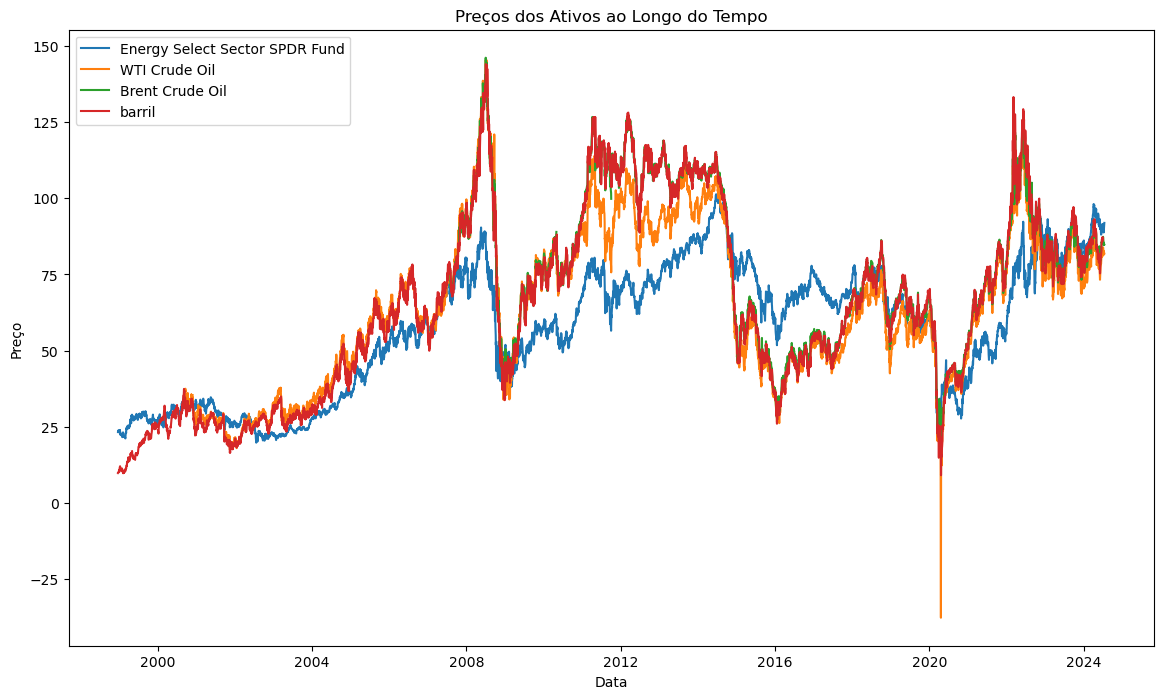

In [20]:
# Visualização de Séries Temporais
plt.figure(figsize=(14, 8))
for column in df_ativos.columns:
    if column != 'Year':  # Excluir a coluna 'Year' da visualização
        plt.plot(df_ativos.index, df_ativos[column], label=column)
plt.title('Preços dos Ativos ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


### Análise da Série Temporal

1. **Tendência de Alta de Longo Prazo (1998-2008)**:
   - Os preços dos ativos relacionados ao petróleo mostraram uma tendência de alta consistente de 1998 até 2008. Esta tendência pode estar relacionada ao crescimento econômico global e ao aumento da demanda por petróleo.

2. **Crise Financeira Global (2008-2009)**:
   - Em 2008, há uma queda acentuada nos preços dos ativos, coincidente com a crise financeira global. Esta queda foi resultado de uma contração econômica global, que reduziu a demanda por petróleo.

3. **Recuperação Pós-Crise (2009-2014)**:
   - Após a crise de 2008-2009, os preços dos ativos começaram a se recuperar, atingindo novos picos em torno de 2012-2014. Isso pode estar associado à recuperação econômica global e ao aumento da demanda por petróleo.

4. **Queda dos Preços do Petróleo (2014-2016)**:
   - Entre 2014 e 2016, os preços do petróleo caíram significativamente devido a um excesso de oferta global de petróleo, incluindo o aumento da produção de petróleo de xisto nos Estados Unidos.

5. **Oscilações e Recuperação (2016-2019)**:
   - Após a queda de 2014-2016, os preços dos ativos mostraram oscilações, mas mantiveram uma tendência de recuperação moderada até 2019.

6. **Impacto da Pandemia de COVID-19 (2020)**:
   - Em 2020, há uma queda abrupta e temporária nos preços do petróleo, coincidindo com a pandemia de COVID-19. Isso resultou em uma queda drástica na demanda por petróleo devido a lockdowns globais e restrições de viagens, levando até a preços negativos em contratos futuros de petróleo, como observado no WTI Crude Oil.

7. **Recuperação Pós-Pandemia (2021-2024)**:
   - Após o impacto inicial da pandemia, os preços dos ativos voltaram a subir conforme a demanda por petróleo começou a se recuperar. Esta recuperação é visível na série temporal até 2024.

### Insights Específicos:

- **Correlação entre Ativos**:
  - Os preços dos diferentes ativos (Energy Select Sector SPDR Fund, WTI Crude Oil, Brent Crude Oil, e o preço do barril de petróleo Brent) tendem a se mover juntos, indicando alta correlação entre eles. Isso pode ser visto nas tendências e oscilações similares ao longo do tempo.
  
- **Volatilidade**:
  - A volatilidade é evidente em vários períodos, especialmente durante crises econômicas e eventos globais significativos, como a crise financeira de 2008 e a pandemia de COVID-19 em 2020.

- **Resiliência e Recuperação**:
  - O mercado de petróleo mostrou resiliência, com preços se recuperando após quedas significativas. A recuperação pós-crise financeira e pós-pandemia são exemplos notáveis dessa resiliência.

## 3.3 Análise de correlação

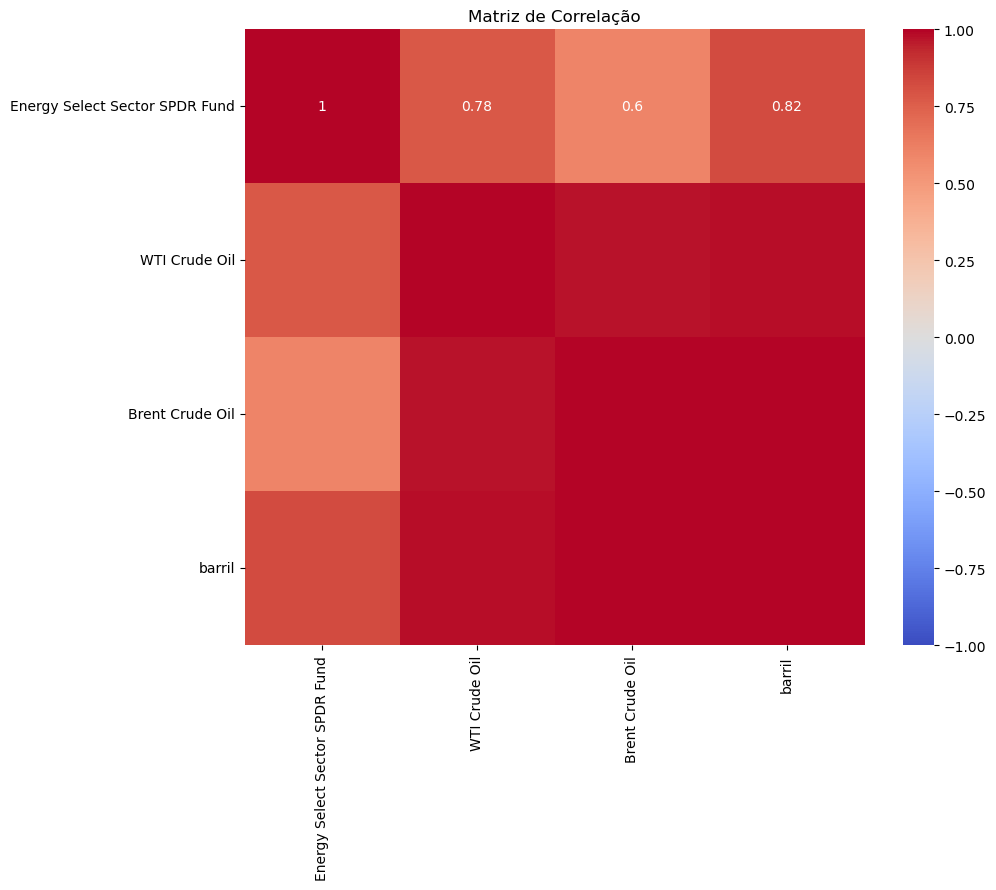

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
Energy Select Sector SPDR Fund,1.000000,0.778755,0.597121,0.822582
WTI Crude Oil,0.778755,1.000000,0.973940,0.980815
Brent Crude Oil,0.597121,0.973940,1.000000,0.996401
barril,0.822582,0.980815,0.996401,1.000000


In [23]:
# Calcular a matriz de correlação
correlation_matrix = df_ativos.corr()

# Exibir a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

# Mostrar a matriz de correlação como dataframe
correlation_matrix

### Análise da Correlação Focada no Barril

Vamos focar na correlação do preço do barril de petróleo Brent ("barril") com os demais ativos:

1. **Correlação entre Barril e Energy Select Sector SPDR Fund (0.822582)**:
   - **Correlação Positiva Forte**: Uma correlação de 0.82 indica uma relação positiva forte entre o preço do barril de petróleo Brent e o Energy Select Sector SPDR Fund. Isso sugere que, quando o preço do barril aumenta, o preço do fundo de energia também tende a aumentar. Essa relação forte pode ser explicada pelo fato de que empresas dentro do Energy Select Sector SPDR Fund são diretamente afetadas pelos preços do petróleo, que impactam seus custos e receitas.

2. **Correlação entre Barril e WTI Crude Oil (0.980815)**:
   - **Correlação Positiva Muito Forte**: A correlação de 0.98 indica uma relação quase perfeita entre o preço do barril de petróleo Brent e o WTI Crude Oil. Isso significa que os preços dos dois tipos de petróleo tendem a se mover juntos quase exatamente. Essa alta correlação é esperada, dado que ambos são benchmarks globais para preços do petróleo e estão sujeitos a influências semelhantes do mercado global.

3. **Correlação entre Barril e Brent Crude Oil (0.996401)**:
   - **Correlação Positiva Quase Perfeita**: A correlação de 0.996 é praticamente perfeita, o que é intuitivo, pois "barril" refere-se ao preço do Brent Crude Oil. Portanto, qualquer movimento no preço do Brent Crude Oil é refletido diretamente no preço do barril de petróleo Brent. Esta correlação quase perfeita confirma que estamos lidando com dados praticamente idênticos.

## 3.4 Análise de dados ausentes

Contagem de Valores Ausentes por Coluna:
Energy Select Sector SPDR Fund       4
WTI Crude Oil                      436
Brent Crude Oil                   2224
barril                              54
dtype: int64


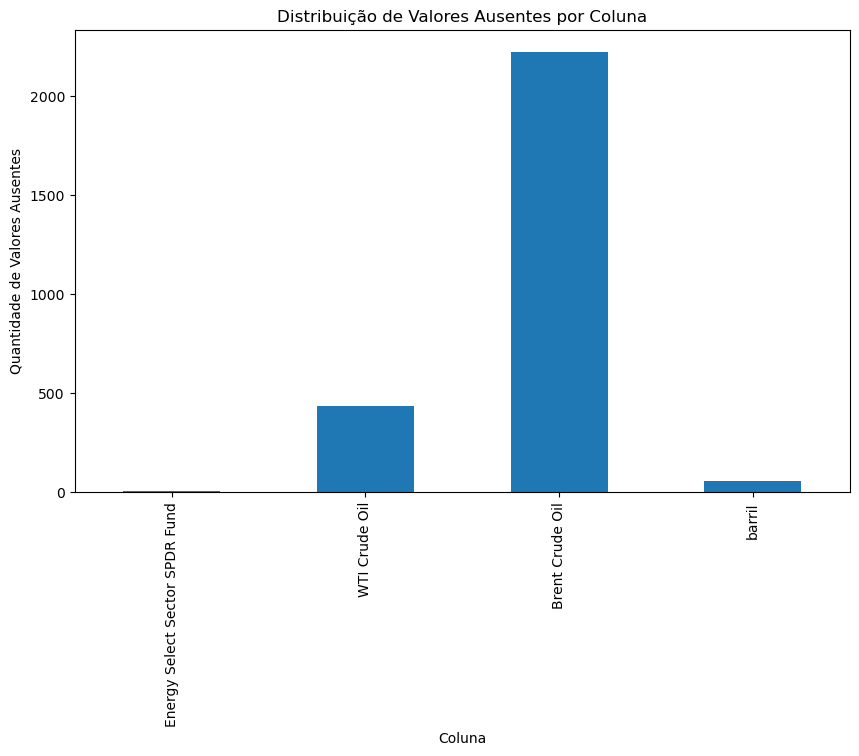

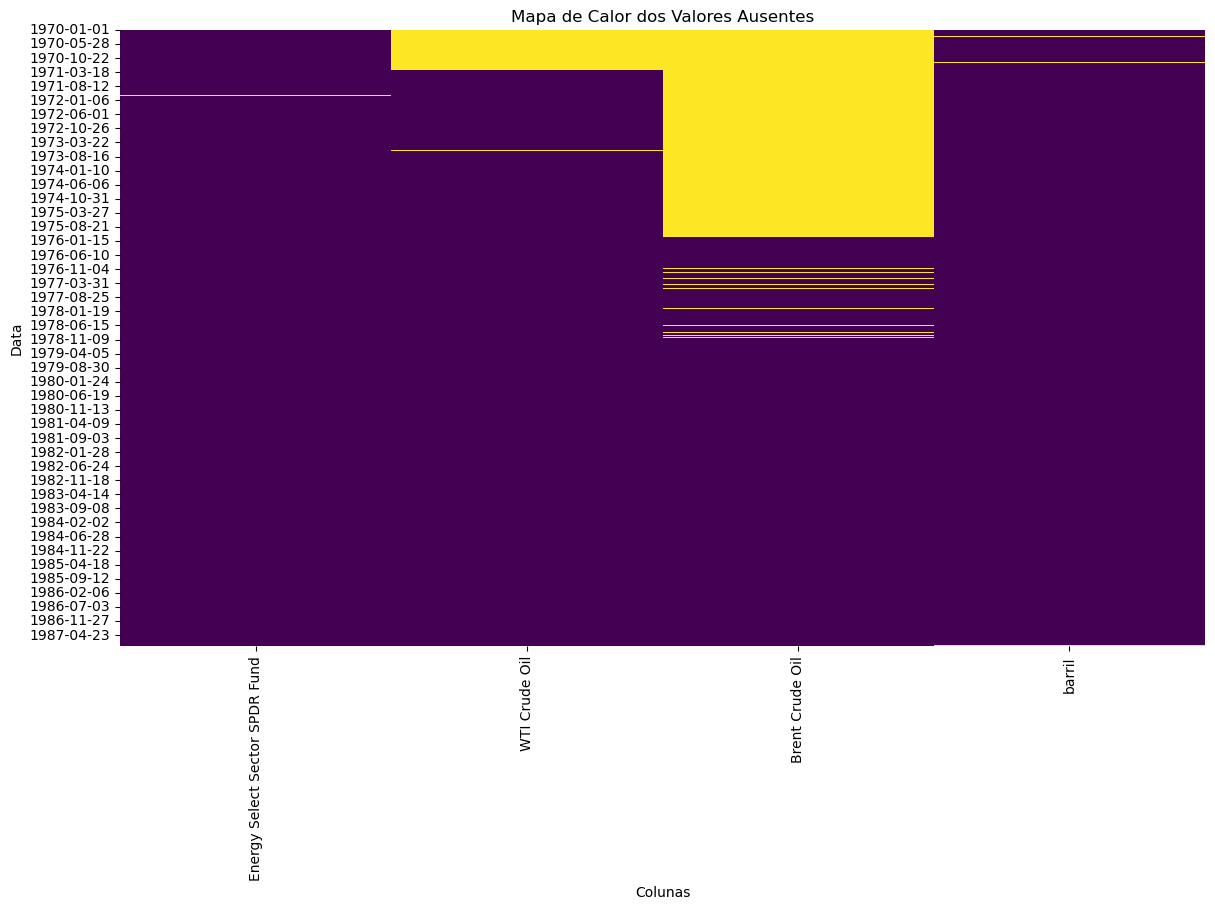

In [26]:
# Contar os Valores Ausentes
missing_values_count = df_ativos.isna().sum()

# Exibir a Contagem de Valores Ausentes
print("Contagem de Valores Ausentes por Coluna:")
print(missing_values_count)

# Visualização da Distribuição dos Valores Ausentes
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.title('Distribuição de Valores Ausentes por Coluna')
plt.xlabel('Coluna')
plt.ylabel('Quantidade de Valores Ausentes')
plt.show()

# Mapa de Calor dos Valores Ausentes
plt.figure(figsize=(14, 8))
sns.heatmap(df_ativos.isna(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor dos Valores Ausentes')
plt.xlabel('Colunas')
plt.ylabel('Data')

# Formatar a data no eixo Y
ax = plt.gca()
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.show()

# 4. Limpeza de dados

Optamos por considerar os dados de 2014 em diante

In [28]:
# Filtrando os dados de 2014 em diante
df_filtered = df_ativos[df_ativos.index >= '2014-01-01']

<Axes: xlabel='Date'>

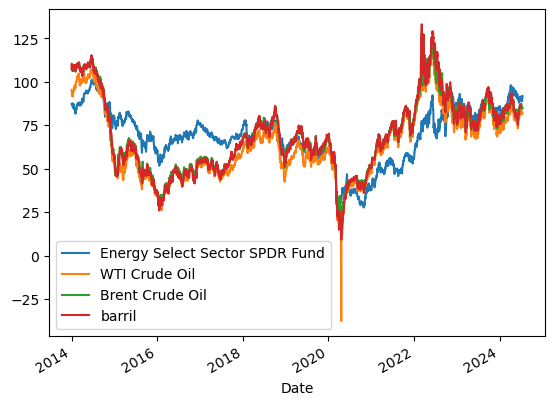

In [29]:
df_filtered.plot()

In [30]:
# Definindo o intervalo de datas a ser deletado
start_date = '2020-03-16'
end_date = '2020-05-13'

# Filtrando e deletando as datas dentro do intervalo
df_filtered = df_filtered.drop(df_filtered.loc[start_date:end_date].index)

* Optamos por excluir os dados de março de 2020 devido ao início da pandemia, que apresentou um comportamento significativamente atípico.

<Axes: xlabel='Date'>

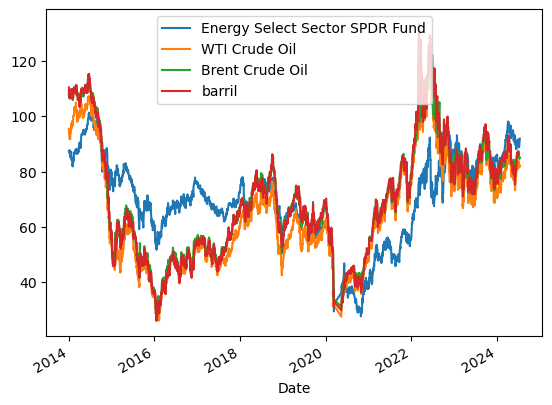

In [32]:
df_filtered.plot()

In [33]:
df_filtered.isnull().sum()

Energy Select Sector SPDR Fund     1
WTI Crude Oil                      2
Brent Crude Oil                    9
barril                            35
dtype: int64

In [34]:
df_filtered.dropna(inplace=True)

* Devido à quantidade baixa de valores nulos, decidimos remover essas linhas.

# 5. Criando o Modelo

## 5.1 Decomposição da Série Temporal

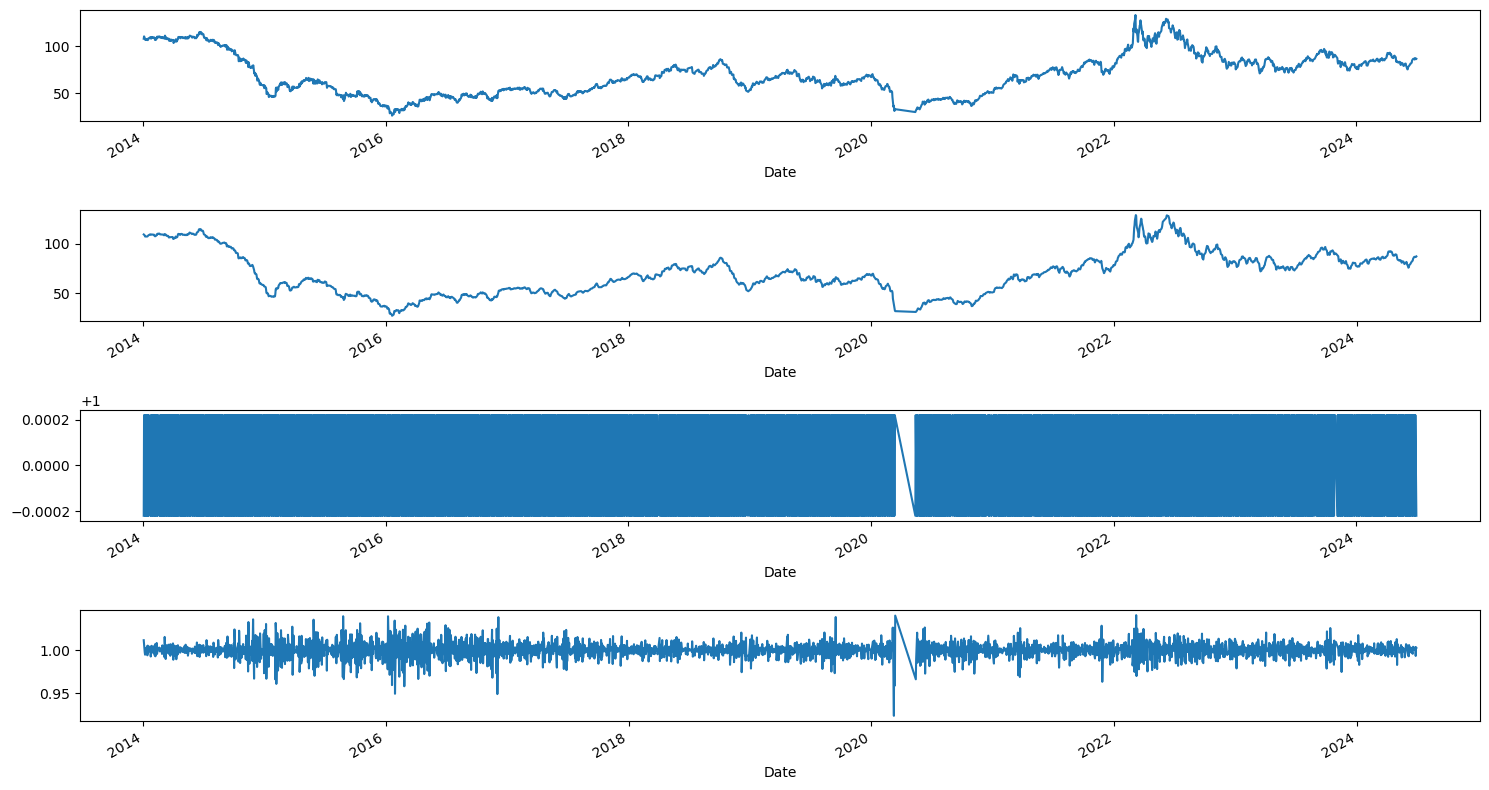

In [38]:
df = df_filtered[['barril']]
seasonplot = seasonal_decompose(df, model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## 5.2 Teste adfuller
Métado para um teste estatístico com a finalidade de aceitar/recusar a hipótese da série ser estacionária

H0 - Hipótese nula (Não é estacionária) H1 - Hipótese alternativa (a série é estacionária)

Quanto maior o p-value, mais evidencia contra a hipótese nula se tem

Rejeitamos a hipótese nula se o p-value for menor que 0.05, ou seja, estamos trabalhando com um intervalode confiança de 95%

In [40]:
# Teste na base completa
sns.set_style('darkgrid')
X = df_filtered.barril.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-value: {result[1]}')
print(f'Valores criticos: ')

for key, value in result[4].items():
    print(f'\t {key}: {value}')

Teste ADF
Teste estatístico: -2.414008733727529
P-value: 0.13782152087377714
Valores criticos: 
	 1%: -3.432919034594598
	 5%: -2.862674995236558
	 10%: -2.5673742003270332


* O valor-p é maior que 0.05 e o teste estatístico é maior que os valores críticos de 1%, 5% e 10%. Portanto, não rejeitamos a hipótese nula (H0) de que a série possui uma raiz unitária, indicando que a série não é estacionária.







## 5.3 Criando um modelo SARIMAX

### Divisão da Base de Dados

Nesta etapa, dividimos a base de dados em duas partes: treino e teste. A base de teste consiste nos últimos 30 dias da base completa, enquanto a base de treino abrange o restante dos dados.

### Implementação do GridSearch

Realizamos uma implementação da técnica de GridSearch com os seguintes parâmetros:

| Parâmetro | Valores Possíveis |
|-----------|-------------------|
| p         | 0, 1, 2, 3        |
| d         | 0, 1              |
| q         | 0, 1, 2, 3        |
| P         | 0, 1, 2           |
| D         | 0, 1              |
| Q         | 0, 1, 2           |
| m         | 6 (Sazonalidade)  |

### Processo de Treinamento

O GridSearch envolveu cerca de 576 treinamentos. Selecionamos o melhor conjunto de hiperparâmetros com base na performance na base de treino.

### Previsão e Avaliação

Após selecionar os melhores hiperparâmetros, realizamos a previsão para os próximos 30 dias e comparamos os resultados com os valores da base de teste. A métrica utilizada para avaliar a performance foi o MAPE (Mean Absolute Percentage Error).

In [43]:
df = df_filtered[['barril']].copy()

In [44]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Supondo que seu DataFrame 'df' já está carregado e tem a coluna 'barril'
# Assegurando que 'Date' está definido como índice e é do tipo datetime
df.index = pd.to_datetime(df.index)

# Separar os últimos 30 dias como conjunto de teste
intervalo_dias = 30
test_size = intervalo_dias
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

# Definir os parâmetros para o grid search
p_values = [0, 1, 2, 3]
d_values = [0, 1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
m = 6  # Sazonalidade

best_score, best_cfg = float("inf"), None

# Função para realizar a busca dos melhores parâmetros

# Calcular o total de iterações
total_iterations = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values)

progress_bar = tqdm(total=total_iterations, desc="Treinamentos realizados")

c = 0
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            model = SARIMAX(train_data['barril'], order=order, seasonal_order=seasonal_order)
                            result = model.fit(disp=False)
                            forecast = result.predict(start=0, end=len(train_data)-1)
                            mape = mean_absolute_percentage_error(train_data['barril'], forecast)
                            if mape < best_score:
                                best_score, best_cfg = mape, (order, seasonal_order)
                            #print(f"N SARIMA{order}x{seasonal_order} - MAPE:{mape:.4f}")
                        except Exception as e:
                            continue
                        finally:
                            progress_bar.update(1)
progress_bar.close()

print(f'Best SARIMA (Base de Treino){best_cfg[0]}x{best_cfg[1]} - MAPE (train):{best_score:.4f}')

# Treinar o modelo SARIMAX com os melhores parâmetros encontrados
best_order, best_seasonal_order = best_cfg
model = SARIMAX(train_data['barril'], order=best_order, seasonal_order=best_seasonal_order)
result_sarimax = model.fit()

# Fazer previsões para os próximos 30 dias
forecast = result_sarimax.forecast(steps=test_size)
forecast.index = test_data.index
test_data['yhat'] = forecast

# Calcular o erro percentual absoluto para cada ponto de dados
test_data['erro_percentual_absoluto'] = np.where(
    test_data['barril'] != 0, 
    np.abs((test_data['barril'] - test_data['yhat']) / test_data['barril']) * 100,
    np.nan  # Ignorar casos onde o valor real é zero para evitar divisão por zero
)

# Calcular o MAPE ignorando os valores NaN
mape = np.nanmean(test_data['erro_percentual_absoluto'])

print(f"MAPE (30 dias - Base Teste): {mape:.2f}%")


Treinamentos realizados: 100%|██████████| 576/576 [38:51<00:00,  4.05s/it]  
 This problem is unconstrained.


Best SARIMA (Base de Treino)(3, 1, 2)x(0, 0, 0, 6) - MAPE (train):0.0187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96687D+00    |proj g|=  1.49662D-01

At iterate    5    f=  1.96540D+00    |proj g|=  7.62399D-02

At iterate   10    f=  1.96499D+00    |proj g|=  5.54347D-03

At iterate   15    f=  1.96491D+00    |proj g|=  1.79634D-02

At iterate   20    f=  1.96490D+00    |proj g|=  1.19112D-03

At iterate   25    f=  1.96487D+00    |proj g|=  1.23465D-02

At iterate   30    f=  1.96431D+00    |proj g|=  1.35621D-02

At iterate   35    f=  1.96400D+00    |proj g|=  5.54138D-03

At iterate   40    f=  1.96395D+00    |proj g|=  1.13416D-02

At iterate   45    f=  1.96360D+00    |proj g|=  6.38230D-02

At iterate   50    f=  1.96351D+00    |proj g|=  2.51708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of 

### 5.3.1 Avaliação do modelo SARIMAX

In [46]:
# Recalculando métricas com o nome correto do dataframe
mae = mean_absolute_error(test_data["barril"], test_data["yhat"])
mse = mean_squared_error(test_data["barril"], test_data["yhat"])
rmse = mse ** 0.5
mape = (test_data["erro_percentual_absoluto"].mean())
r2 = r2_score(test_data["barril"], test_data["yhat"])

# Mostrar resultados
metricas = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "Mean Absolute Percentage Error (MAPE)": mape,
    "R-squared (R²)": r2
}

metricas_df = pd.DataFrame(metricas, index=[0])
metricas_df.T

,0
Mean Absolute Error (MAE),2.802114
Mean Squared Error (MSE),12.366249
Root Mean Squared Error (RMSE),3.516568
Mean Absolute Percentage Error (MAPE),3.417127
R-squared (R²),-0.004183


1. **Mean Absolute Error (MAE)**: 2.802114
   - **Interpretação**: O MAE representa a média dos erros absolutos entre os valores reais e previstos. Um MAE de aproximadamente 2.8 indica que, em média, as previsões do modelo estão a cerca de 2.8 unidades (no caso, dólares) de diferença do valor real do preço do barril de petróleo.

2. **Mean Squared Error (MSE)**: 12.366249
   - **Interpretação**: O MSE é a média dos quadrados dos erros e penaliza mais os erros maiores. Um MSE de 12.367 sugere que há alguns erros maiores nas previsões do modelo, pois a métrica eleva ao quadrado as diferenças antes de calcular a média.

3. **Root Mean Squared Error (RMSE)**: 3.516568
   - **Interpretação**: O RMSE é a raiz quadrada do MSE e está na mesma unidade dos dados originais. Um RMSE de 3.517 indica que, em média, os erros das previsões estão a cerca de 3.5 unidades do valor real do preço do barril de petróleo. Este valor é um pouco maior que o MAE, reforçando que há alguns erros maiores presentes.

4. **Mean Absolute Percentage Error (MAPE)**: 3.417127%
   - **Interpretação**: O MAPE é a média dos erros percentuais absolutos. Um MAPE de aproximadamente 3.42% significa que, em média, a previsão do modelo é 3.42% diferente do valor real. Este é um valor relativamente baixo, indicando que o modelo é bastante preciso em termos percentuais.

5. **R-squared (R²)**: -0.004183
   - **Interpretação**: O R² é o coeficiente de determinação e mede a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. Um valor de R² negativo, como -0.004, sugere que o modelo está se ajustando pior do que uma média simples dos valores reais (ou seja, uma linha horizontal ao longo da média dos valores reais). Isso é um sinal de que o modelo não está capturando bem a relação subjacente nos dados.

Essa análise sugere que, embora o modelo SARIMAX esteja fornecendo previsões relativamente precisas em termos de erro absoluto e percentual, ele pode não estar capturando toda a variabilidade dos dados, como indicado pelo valor negativo de R².

## 5.4 Modelo fbprophet

In [49]:
# Renomear colunas para o formato esperado pelo Prophet
df.reset_index(inplace=True)
df = df.rename(columns={'Date': 'ds', 'barril': 'y'})

18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1]

Melhores Hiperparâmetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
MAE: 3.2027255410226325
RMSE: 3.634565614514504
R²: -0.0727038584038533


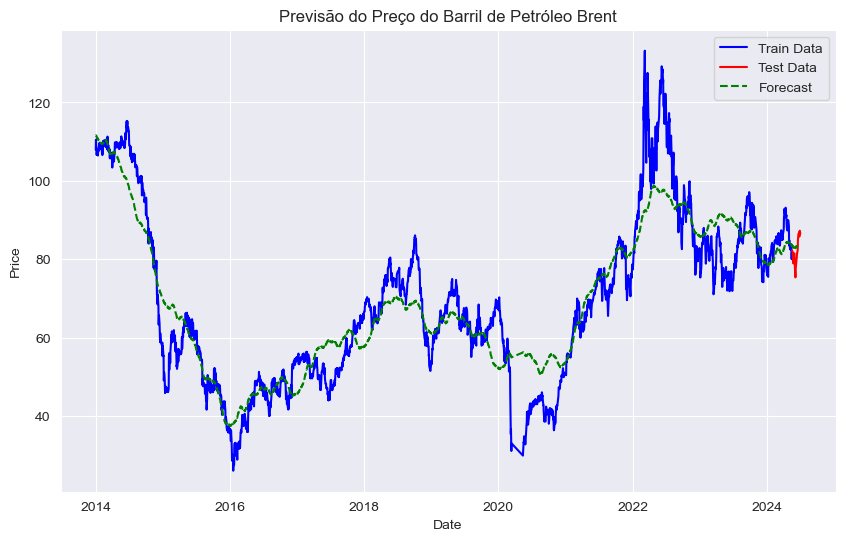

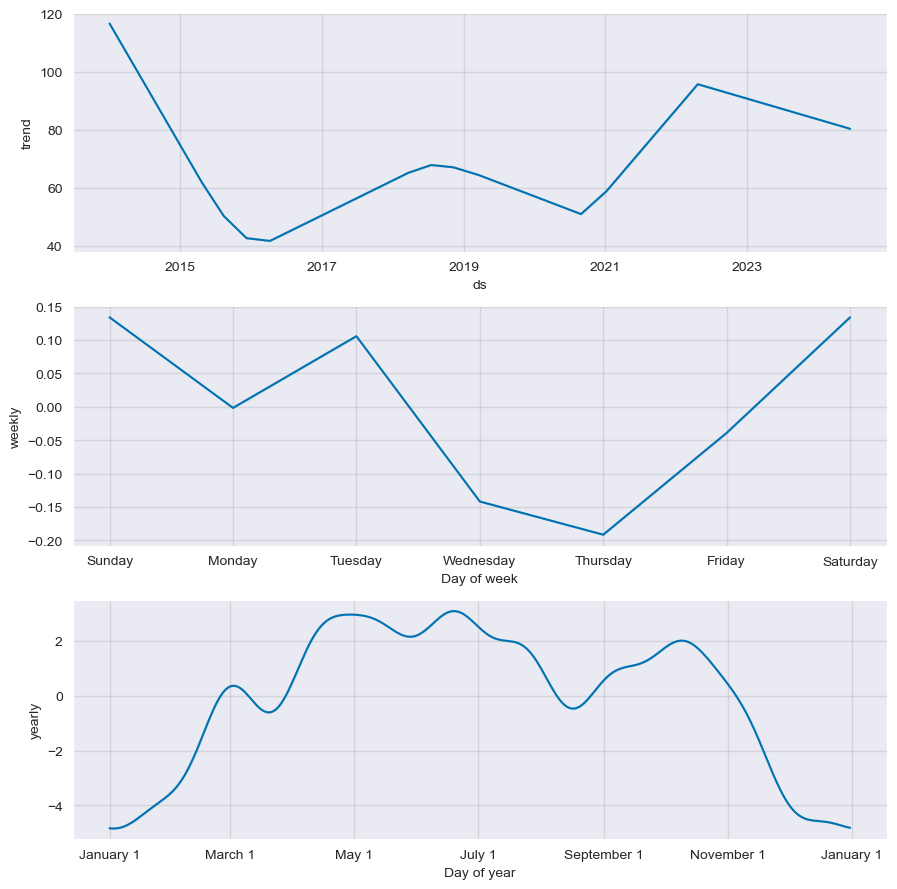

In [50]:
# Dividir em treino e teste
intervalo_dias = 30
train = df[:-intervalo_dias]
test = df[-intervalo_dias:]

# Definir a função para realizar GridSearch
def gridsearch_prophet(train, param_grid):
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    best_params = None
    best_mae = float("inf")
    for params in all_params:
        model = Prophet(**params)
        model.fit(train)
        future = model.make_future_dataframe(periods=intervalo_dias)
        forecast = model.predict(future)
        forecast = forecast[-intervalo_dias:]
        mae = mean_absolute_error(test['y'], forecast['yhat'])
        if mae < best_mae:
            best_mae = mae
            best_params = params
    return best_params, best_mae

# Definir os hiperparâmetros para o GridSearch
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0]
}

'''
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality': [5, 10, 20],
    'weekly_seasonality': [5, 10, 20],
    'daily_seasonality': [5, 10, 20]
}
'''

# Realizar o GridSearch
best_params, best_mae = gridsearch_prophet(train, param_grid)

# Ajustar o melhor modelo
best_model = Prophet(**best_params)
best_model.fit(train)
future = best_model.make_future_dataframe(periods=intervalo_dias)
forecast = best_model.predict(future)

# Calcular métricas de avaliação
mae = mean_absolute_error(test['y'], forecast['yhat'][-intervalo_dias:])
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-intervalo_dias:]))
r2 = r2_score(test['y'], forecast['yhat'][-intervalo_dias:])

# Gerar relatório com as métricas de avaliação
print(f"Melhores Hiperparâmetros: {best_params}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Plotar os resultados
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar dados de treino
ax.plot(train['ds'], train['y'], label='Train Data', color='blue')

# Plotar dados de teste
ax.plot(test['ds'], test['y'], label='Test Data', color='red')

# Plotar previsões
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green', linestyle='dashed')

# Adicionar título e legendas
ax.set_title('Previsão do Preço do Barril de Petróleo Brent')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Mostrar o gráfico
plt.show()

# Visualizar componentes da previsão
best_model.plot_components(forecast)
plt.show()

In [51]:
df

,ds,y
0,2014-01-02,107.94
1,2014-01-03,110.47
2,2014-01-06,107.94
3,2014-01-07,106.57
4,2014-01-08,107.42
...,...,...
2560,2024-06-25,86.81
2561,2024-06-26,85.76
2562,2024-06-27,87.00
2563,2024-06-28,87.26


## 5.5 Modelo ARIMA

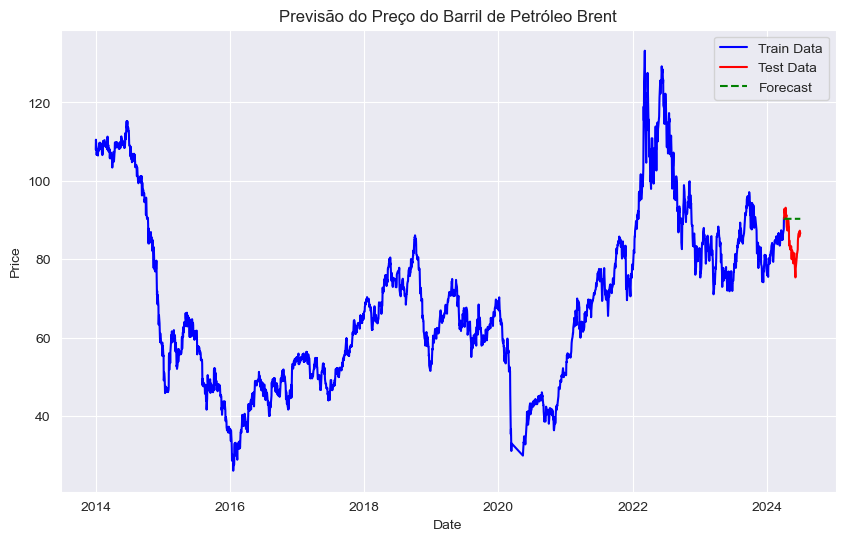

MAE: 6.160709941674144
RMSE: 7.375138923072529
R²: -1.5338526870105507


In [53]:
# Dividir em treino e teste
intervalo_dias = 60
train = df[:-intervalo_dias]
test = df[-intervalo_dias:]

# Ajustar o modelo ARIMA
model = ARIMA(train['y'], order=(5, 1, 0))  # Ordem (p,d,q) pode ser ajustada
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=intervalo_dias)
forecast_index = test['ds']

# Plotar os resultados
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar dados de treino
ax.plot(train['ds'], train['y'], label='Train Data', color='blue')

# Plotar dados de teste
ax.plot(test['ds'], test['y'], label='Test Data', color='red')

# Plotar previsões
ax.plot(forecast_index, forecast, label='Forecast', color='green', linestyle='dashed')

# Adicionar título e legendas
ax.set_title('Previsão do Preço do Barril de Petróleo Brent')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Mostrar o gráfico
plt.show()

# Calcular métricas de avaliação
mae = mean_absolute_error(test['y'], forecast)
rmse = np.sqrt(mean_squared_error(test['y'], forecast))
r2 = r2_score(test['y'], forecast)

# Gerar relatório com as métricas de avaliação
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")